In [2]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import math
import matplotlib.pyplot as plt

import nltk
import re

from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords

from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier

# nltk.download('punkt')
# nltk.download('wordnet')
# nltk.download('stopwords')

from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score, balanced_accuracy_score, average_precision_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

from IPython.display import display

In [3]:
# !pip install joblib scikit-learn

# Load Data and Perform Data Filtering and Transformation

In [4]:

os.chdir(r"C:\Users\Celeste\Google Drive Streaming\My Drive\_CODEOP\project\data")

df = pd.read_csv('final_data.csv', encoding='utf-8')

# Cleaning columns ans filtering "Birth Control"
filtered_df = df[df['condition'] == 'Birth Control'].drop(
    columns=['Unnamed: 0', 'condition', 'date', 'usefulCount', 'matched_generic_name', 'matched_type']
)

filtered_df.head()


,provided_drug_name,review,rating
0,Lybrel,"""I used to take another oral contraceptive, wh...",5
1,Ortho Evra,"""This is my first time using any form of birth...",8
3,Ethinyl estradiol / levonorgestrel,"""I had been on the pill for many years. When m...",8
4,Nexplanon,"""Started Nexplanon 2 months ago because I have...",3
5,Etonogestrel,"""Nexplanon does its job. I can have worry free...",9


In [5]:
#filtered_df.info()

In [6]:
summary = f"""
Summary of DataFrame:
--------------------------------------
- Number of rows: {filtered_df.shape[0]}
- Number of columns: {filtered_df.shape[1]}
- Column names: {', '.join(filtered_df.columns)}
- Data types:
{filtered_df.dtypes.to_string()}
- Non-null counts:
{filtered_df.count().to_string()}"""

print(summary)



Summary of DataFrame:
--------------------------------------
- Number of rows: 28788
- Number of columns: 3
- Column names: provided_drug_name, review, rating
- Data types:
provided_drug_name    object
review                object
rating                 int64
- Non-null counts:
provided_drug_name    28788
review                28788
rating                28788


In [7]:
filtered_df.rename(columns= {"provided_drug_name":"drugname"}, inplace= True)

# Labeling Function and Target Distribution Analysis

In [8]:
#label  pos and neg

def label_rating(rating):
    if rating <= 5:
        return 'Negative'
    else:
        return 'Positive'

In [9]:
filtered_df['target'] = filtered_df['rating'].apply(label_rating)
filtered_df.head()

,drugname,review,rating,target
0,Lybrel,"""I used to take another oral contraceptive, wh...",5,Negative
1,Ortho Evra,"""This is my first time using any form of birth...",8,Positive
3,Ethinyl estradiol / levonorgestrel,"""I had been on the pill for many years. When m...",8,Positive
4,Nexplanon,"""Started Nexplanon 2 months ago because I have...",3,Negative
5,Etonogestrel,"""Nexplanon does its job. I can have worry free...",9,Positive


In [10]:
filtered_df.isnull().sum()

drugname    0
review      0
rating      0
target      0
dtype: int64

In [11]:
pd.set_option('display.max_colwidth', None)

In [12]:
#Check out target distribution

target_distr = filtered_df["target"].value_counts()
target_distr*100/len(filtered_df)

# 57% of the ratings are "Positive" and  43% are "Negative". A bit imbalanced dataset


target
Positive    57.444074
Negative    42.555926
Name: count, dtype: float64

# Preprocessing Steps

In [13]:
# Seeing what reviews looks like
text = filtered_df.review.iloc[1]
print(text)

"This is my first time using any form of birth control. I&#039;m glad I went with the patch, I have been on it for 8 months. At first It decreased my libido but that subsided. The only downside is that it made my periods longer (5-6 days to be exact) I used to only have periods for 3-4 days max also made my cramps intense for the first two days of my period, I never had cramps before using birth control. Other than that in happy with the patch"


In [14]:
# Def RegEx

REPLACE_NO_SPACE = re.compile(r"[.;:!#\'?,\"()\[\]&]|\d+")  # delete punctuation and numbers
REPLACE_WITH_SPACE = re.compile(r"(<br\s*/><br\s*/>)|(\-)|(\/)") 

# We want to remove everything that is not a proper character. RegEx for non-alphanumerical characters.

In [15]:
#Preprocess function for "review" column

stop_words = set(stopwords.words('english'))

def preprocess_review(reviews):

    # Remove special characters
    reviews = re.sub(REPLACE_NO_SPACE, "", reviews)  #aqui tambien podemos usar RegexpTokenizer()
    reviews = re.sub(REPLACE_WITH_SPACE, " ", reviews)

    tokens = word_tokenize(reviews)

    # Lowercase and lemmatize
    lemmatizer = WordNetLemmatizer()

    lemmas = [lemmatizer.lemmatize(token.lower(), pos='v') for token in tokens if token.lower() not in stop_words]
    lemmas = [lemmatizer.lemmatize(token.lower(), pos='n') for token in lemmas if token.lower() not in stop_words]


    return lemmas


### Sanity check ____________________________________________________________________________________________________________________________________________________________________________


In [16]:
start = text.find("of birth control. I&#039;m glad I went with")
end = start + len("of birth control. I&#039;m glad I went with")
print(f"Start position: {start}")
print(f"End position: {end}")
text = filtered_df['review'][1][38:81]
print(text)

preprocess_review(text)

Start position: 38
End position: 81
of birth control. I&#039;m glad I went with


['birth', 'control', 'im', 'glad', 'go']


____________________________________________________________________________________________________________________________________________________________________________

# Splitting the Data into Training and Test Sets

In [17]:
# X = independent variable = review,  y = target variable (dependent) = rating

X = filtered_df['review']
y= filtered_df['target']

# why we are doing these? video: 1:20

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [18]:
print("DataFrame dimensions:", filtered_df.shape)
print(f"Train dimensions: {X_train.shape, y_train.shape}")  
print(f"Test dimensions: {X_test.shape, y_test.shape}")  

DataFrame dimensions: (28788, 4)
Train dimensions: ((23030,), (23030,))
Test dimensions: ((5758,), (5758,))


In [19]:
# Check the distribution of classes in the training and testing sets

print(y_train.value_counts())
print(y_test.value_counts())

# Both has the same proportion, 74% --> stratified

target
Positive    13232
Negative     9798
Name: count, dtype: int64
target
Positive    3305
Negative    2453
Name: count, dtype: int64


In [20]:
X_train.head()

26256                                                     "I switched to this pill after using Sprintec for years and had instant weight gain. I gained 20 pounds in the first three months. No noticeable changes in mood, sex drive, or acne. My skin stayed very clear. I also stopped having a period completely and although it was wonderful I could not get used to it. The pregnancy panics along with the weight gain forced me to stop taking these pills."
22909                                         "I&#039;ve had it for 2 weeks so far no side effects yay!!! I don&#039;t get why people keep it in for years if it has crazy side effects like weight gain, suicide etc? The moment I gain 5 lbs I&#039;m getting it out. I have a very very regular workout and diet schd. The only pills that worked for me we&#039;re Yasmin and mini pill but I kept forgetting to take it after my sons birth hence the implanon."
17874                                                                                       

# Vectorizing: Choosing the Right Weighting Scheme

In [21]:
#What is my weighting scheme? in this case, Tfidf beacuse...

# vectoriser = TfidfVectorizer(analyzer=preprocess_review)
# X_train_tfidf = vectoriser.fit_transform(X_train)

In [22]:
# X_train_tfidf.shape # --> representación de una Bag of Words (BoW)

# had in mind: 
# DataFrame dimensions: (31251, 3)
# Train dimensions: ((23030,), (23030,))
# # Test dimensions: ((5758,), (5758,))

# X_train_tfidf es una matriz donde cada fila representa un documento y cada columna representa una palabra (o término)
# en el vocabulario que fue creado a partir de los documentos de entrenamiento.
# Cada entrada en esta matriz corresponde a la importancia de la palabra en el documento,
#  medida por el TF-IDF. 
# 
# output-->(23030, 11644)

(23030, 11644)

In [23]:
#represent test documents in the Vector Space we've learned with the train documents
# X_test_tfidf = vectoriser.transform(X_test)

In [24]:
# X_test_tfidf.shape 
# output-->(5758, 11644)

(5758, 11644)

nlp done

# Wrap-Up: Running the Models Using the Pipeline


## Pipeline: Logistic Regression

In [25]:
import joblib 
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.preprocessing import LabelEncoder

In [26]:
# vectoriser = TfidfVectorizer(analyzer=preprocess_review)
# lr = LogisticRegression()

# pipe_lr = Pipeline([
#     ('vectorizer', vectoriser), 
#     ('classifier', lr)
# ])

# pipe_lr.fit(X_train, y_train)

In [27]:
# Guardar el pipeline de lr
# joblib.dump(pipe_lr, 'pipe_lr.pkl')

# Load  pipeline 
loaded_pipe_lr = joblib.load(r"C:\Users\Celeste\Google Drive Streaming\My Drive\_CODEOP\project\collaborative_project\celes_copy\pipe_lr.pkl")

In [28]:
y_test_pred_lr = loaded_pipe_lr.predict(X_test) #for metrics as Precision, Recall and F1-score
y_test_proba_lr = loaded_pipe_lr.predict_proba(X_test)[:,1] #useful in ROC-AUC 

## Pipeline: Naive-Bayes

In [29]:
vectoriser = TfidfVectorizer(analyzer=preprocess_review)
# nb= MultinomialNB()

# pipe_nb = Pipeline([
#     ('vectoriser', vectoriser),
#     ('classifier', nb)
# ])

# pipe_nb.fit(X_train, y_train)

In [30]:
# Saving pipeline de nb
#joblib.dump(pipe_nb, 'pipe_nb.pkl')

# Load  pipeline 
loaded_pipe_nb = joblib.load(r"C:\Users\Celeste\Google Drive Streaming\My Drive\_CODEOP\project\collaborative_project\celes_copy\pipe_nb.pkl")

In [31]:
y_test_pred_nb = loaded_pipe_nb.predict(X_test)
y_test_proba_nb = loaded_pipe_nb.predict_proba(X_test)[:,1] #probabilidades de la clase positiva

## Pipeline: Random Forest Model

In [32]:
# # Wrap Up Random Forest
# vectoriser = TfidfVectorizer(analyzer=preprocess_review)
# rf= RandomForestClassifier()

# pipe_rf = Pipeline([('vectoriser', vectoriser),
#                  ('classifier', rf)])

# pipe_rf.fit(X_train, y_train)

In [33]:
#joblib.dump(pipe_rf, 'pipe_rf.pkl')

loaded_pipe_rf = joblib.load(r"C:\Users\Celeste\Google Drive Streaming\My Drive\_CODEOP\project\collaborative_project\celes_copy\pipe_rf.pkl")

In [34]:
y_test_pred_rf = loaded_pipe_rf.predict(X_test)
y_test_proba_rf = loaded_pipe_rf.predict_proba(X_test)[:,1]

# Performance Metrics for Models


In [35]:
# Logistic Regression

label_encoder = LabelEncoder()
y_test_encoded = label_encoder.fit_transform(y_test)
y_test_pred_lr_encoded = label_encoder.transform(y_test_pred_lr)

# Balanced Accuracy
balanced_accuracy_lr = balanced_accuracy_score(y_test_encoded, y_test_pred_lr_encoded)

# F1 Score
f1_score_lr = f1_score(y_test_encoded, y_test_pred_lr_encoded)

# ROC AUC
#roc_auc_lr = roc_auc_score(y_test_encoded, y_test_proba_lr[:, 1])  # Da error IndexError
roc_auc_lr = roc_auc_score(y_test_encoded, y_test_proba_lr)


In [36]:
#Logistic Regression 

label_encoder_lr = LabelEncoder()
y_test_encoded = label_encoder_lr.fit_transform(y_test)
y_test_pred_lr_encoded = label_encoder_lr.transform(y_test_pred_lr)

# Balanced Accuracy
balanced_accuracy_lr = balanced_accuracy_score(y_test_encoded, y_test_pred_lr_encoded)
print("Balanced Accuracy (Logistic Regression):", balanced_accuracy_lr)

# F1 Score
f1_score_lr = f1_score(y_test_encoded, y_test_pred_lr_encoded)
print("F1 Score (Logistic Regression):", f1_score_lr)

# ROC AUC usando probabilidades
roc_auc_lr = roc_auc_score(y_test_encoded, y_test_proba_lr)
print("AUC (Logistic Regression):", roc_auc_lr)


Balanced Accuracy (Logistic Regression): 0.8338654141120848
F1 Score (Logistic Regression): 0.8604057099924869
AUC (Logistic Regression): 0.9179436954841798


In [37]:
# Naive-Bayes

label_encoder_nb = LabelEncoder()
y_test_encoded = label_encoder_nb.fit_transform(y_test)
y_test_pred_nb_encoded = label_encoder_nb.transform(y_test_pred_nb)

# Balanced Accuracy
balanced_accuracy_nb = balanced_accuracy_score(y_test_encoded, y_test_pred_nb_encoded)
print("Balanced Accuracy (Naive Bayes):", balanced_accuracy_nb)

# F1 Score
f1_score_nb = f1_score(y_test_encoded, y_test_pred_nb_encoded)
print("F1 Score (Naive Bayes):", f1_score_nb)

# ROC AUC using probabilidades
roc_auc_nb = roc_auc_score(y_test_encoded, y_test_proba_nb)
print("AUC (Naive Bayes):", roc_auc_nb)


Balanced Accuracy (Naive Bayes): 0.7682262541837992
F1 Score (Naive Bayes): 0.8406460296096905
AUC (Naive Bayes): 0.9082310524085794


In [38]:
#Random Forest

# Codificación de etiquetas de prueba
label_encoder_rf = LabelEncoder()
y_test_encoded = label_encoder_rf.fit_transform(y_test)
y_test_pred_rf_encoded = label_encoder_rf.transform(y_test_pred_rf)

# Balanced Accuracy
balanced_accuracy_rf = balanced_accuracy_score(y_test_encoded, y_test_pred_rf_encoded)
print("Balanced Accuracy (Random Forest):", balanced_accuracy_rf)

# F1 Score
f1_score_rf = f1_score(y_test_encoded, y_test_pred_rf_encoded)
print("F1 Score (Random Forest):", f1_score_rf)

# ROC AUC usando probabilidades
roc_auc_rf = roc_auc_score(y_test_encoded, y_test_proba_rf)
print("AUC (Random Forest):", roc_auc_rf)


Balanced Accuracy (Random Forest): 0.9137704117283909
F1 Score (Random Forest): 0.9315392577258613
AUC (Random Forest): 0.9811569149018183


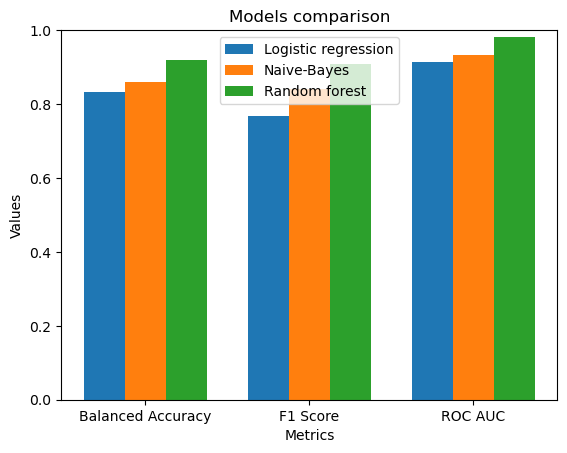

In [41]:
import matplotlib.pyplot as plt
import numpy as np

# Datos
models = ['Logistic regression', 'Naive-Bayes', 'Random forest']
metrics = ['Balanced Accuracy', 'F1 Score', 'ROC AUC']
values = {
    'Logistic regression': {balanced_accuracy_lr, balanced_accuracy_nb, balanced_accuracy_rf},
    'Naive-Bayes': {f1_score_lr, f1_score_nb, f1_score_rf},
    'Random forest': {roc_auc_lr, roc_auc_nb, roc_auc_rf}
}

# Configuración del gráfico
x = np.arange(len(metrics))  # Posiciones de las barras
width = 0.25  # Ancho de las barras

fig, ax = plt.subplots()

# Crear las barras
for i, model in enumerate(models):
    ax.bar(x + i * width, values[model], width, label=model)

# Etiquetas y título
ax.set_xlabel('Metrics')
ax.set_ylabel('Values')
ax.set_title('Models comparison')
ax.set_xticks(x + width)
ax.set_xticklabels(metrics)
ax.legend()

# Mostrar el gráfico
plt.ylim(0, 1)
plt.show()


In [40]:
# average_method = 'weighted'  # Should I use 'macro' or 'micro'?

# # Choose micro when you want a global view of your model’s performance.
# # Choose macro when you want to treat all classes equally, irrespective of their sizes.
# # Choose weighted when dealing with imbalanced classes, as it takes class sizes into account.

# # print(f'Accuracy: {accuracy_score(y_test, nb.predict(X_test_tfidf)):.2f}')  #REMOVE?
# print(f'F1 Score: {f1_score(y_test, nb.predict(X_test_tfidf), average=average_method):.2f}')
# print(f'Precision: {precision_score(y_test, nb.predict(X_test_tfidf), average=average_method):.2f}')
# print(f'Recall: {recall_score(y_test, nb.predict(X_test_tfidf), average=average_method):.2f}')

# # print(f'ROC AUC: {roc_auc_score(y_test, nb.predict_proba(X_test_tfidf)):.2f}')



**Notes**:
average='weighted':
 This parameter is used to compute the metrics for multi-class classification. It accounts for the proportion of each class in the dataset. can change it based on  specific needs (e.g., average='macro' or average='micro').
Given that whe have a binary classification problem with a slight class imbalance (57% positive and 43% negative reviews), we select the next evaluation metrics for our model:

**Precision**: is the proportion of true positive predictions among all positive predictions.

In our context, precision will tell us how many of the reviews predicted as positive are actually positive. High precision means fewer false positives, which is important if you want to ensure that positive reviews are indeed seen as such.

**Recall** (Sensitivity): proportion of true positive predictions among all actual positives. TP/P

Will show how well our model identifies actual positive reviews. In a review context, high recall means that most positive reviews are correctly identified.

**F1 Score**  (Relates precision and recall)

The F1 score is particularly useful for balancing precision and recall, especially when have a slight imbalance. It gives a single score to evaluate your model’s performance, which is beneficial when want to optimize both false positives and false negatives.

As an additional metric: **ROC-AUC**  Measures the model’s ability to distinguish between the positive and negative classes across all thresholds.
Importance:  provides insights into how well your model performs across different thresholds, giving a broader view of its performance regardless of class imbalance.

Why do not use accuracy --< While accuracy can provide a general sense of how well the model performs, it's not the best metric for imbalanced datasets. Since we have a slight imbalance, it might give a misleading impression of model performance, especially if the model predicts the majority class more often.
>

 **y_test** -> true labels 
 **nb.predict(X_test_tfidf)** -> The labels predicted by the model ()).

 **Accuracy** --> 
 - It returns a value between 0 and 1 
 - Represents the proportion of correct predictions relative to the total predictions

# End
